In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from glob import glob
from skimage import io
import os
import matplotlib
from scipy.interpolate import CubicSpline
from lmfit.models import GaussianModel, LorentzianModel
matplotlib.rcParams.update({'errorbar.capsize': 4})


In [173]:
filtAv = [438, 472, 549, 575, 586, 605, 631, 661, 676, 692]
filtUn = np.array([28, 35, 21, 35, 26, 22, 28, 26, 29, 47]) / 2
filtQE = np.array([0.52654585, 0.61510198, 0.67157561, 0.70026282, 0.71884383, 0.7279477, 0.72530424, 0.71414267, 0.68976776, 0.6438945])

ROOTPATH = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/data/img/'

In [111]:
def prepare_spectrum(files, roi):
    nfilt = len(files)
    
    imdark = io.imread(files[-1]).astype(np.int64)
    # img = io.imread(files[0]).astype(np.int64)
    imroi = imdark[roi[0]:roi[1], roi[2]:roi[3]]
    roiSize = imroi.shape[0] * imroi.shape[1]
    offset = 100 * roiSize

    avInt = []
    unInt = []
    for i in range(nfilt-2):
        im = io.imread(files[i]).astype(np.int64)
        img = im - imdark
        imroi = img[roi[0]:roi[1], roi[2]:roi[3]]
        intPx = (imroi.sum() - offset) / roiSize
        avInt.append(intPx)
        
        unPx = np.sqrt((imroi**2).sum()) / roiSize
        unInt.append(unPx)

    avInt = np.array(avInt)
    unInt = np.array(unInt)
    cntQe = avInt / filtQE
    cntQe /= (filtUn*2)

    unInt /= filtQE
    unInt /= (filtUn*2)


    return cntQe, unInt

def plot_spectrum(path, roi, label = None):
    if label == None:
        label = os.path.split(path)[1]
    files = glob(path+'/*.tif')
    files.sort()
    ct, unt = prepare_spectrum(files, roi)

    plt.errorbar(x = filtAv, xerr=filtUn, y = ct, yerr=unt, fmt='o-', label=label)

    plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$')
    plt.legend()
    return ct, unt

In [ ]:
def bin_values(emext):
    binned_values = []
    for center, width in zip(filtAv, filtUn):
        λ_min, λ_max = center - width, center + width
        
        # Select values in range using index
        filtered_counts = emext.loc[λ_min:λ_max, "counts"]
        
        if not filtered_counts.empty:
            avg_counts = filtered_counts.mean()  # Average over the range
        else:
            avg_counts = np.nan  # No data in range
        
        binned_values.append(avg_counts)

    binned_values = np.array(binned_values)
    return binned_values

# Plot reference spectrum

### Sources
H. Du, R. A. Fuh, J. Li, A. Corkan, J. S. Lindsey, "PhotochemCAD: A computer-aided design and research tool in photochemistry," Photochem. Photobiol., 68, 141-142, 1998. 

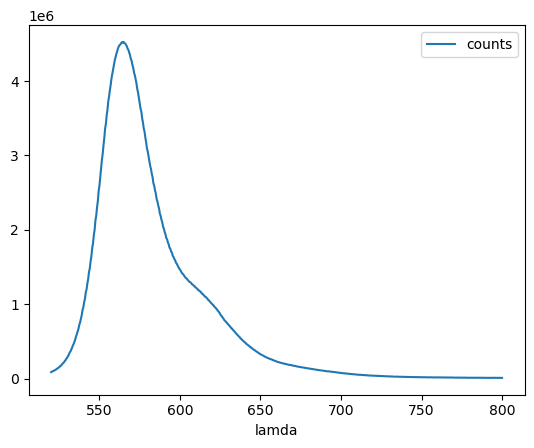

In [71]:
file_em = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectra/emission/Rhodamine-B/Rhodamine_B_emission.txt'
emdf = pd.read_csv(file_em, sep='\t', skiprows=13, names=['lamda', 'counts'])
emdf = emdf.iloc[:-1]
emdf['lamda'] = emdf['lamda'].astype('float')
emdf = emdf.set_index('lamda')
emdf.plot()

### Extend to 400 nm

In [133]:
intensity = emdf['counts'].loc[wavelength].values
len(intensity), len(wavelength)

(60, 60)

Extrapolated intensity at 500 nm (should be 0): 0.7925930351950045


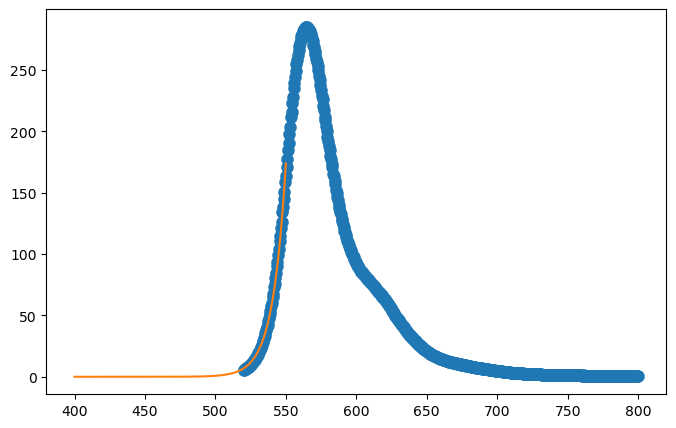

In [144]:
from scipy.optimize import curve_fit

# Sample data (replace with actual data)
wavelength = emdf.index[emdf.index < 550]
intensity = emdf['counts'].loc[wavelength].values

# Define a shifted logarithmic function for fitting, ensuring I(500) = 0
def exp_fit(x, A, B):
    return A * np.exp(B * (x - 400))

# Fit the exponential function to the data
params, _ = curve_fit(exp_fit, wavelength, intensity, p0=[1, 0.1])  # Initial guess for A and B

# Generate values for extrapolation from 500 nm to 550 nm
wavelength_extrapolated = np.linspace(400, 550, 200)
intensity_extrapolated = exp_fit(wavelength_extrapolated, *params)

# Predict intensity at 500 nm
intensity_500 = exp_fit(500, *params)
print(f"Extrapolated intensity at 500 nm (should be 0): {intensity_500}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(emdf, 'o', label="Original Data", markersize=8)
plt.plot(wavelength_extrapolated, intensity_extrapolated, '-', label="Logarithmic Fit (Extrapolated)")


In [211]:
dfext = pd.DataFrame(intensity_extrapolated[wavelength_extrapolated < 520], index=wavelength_extrapolated[wavelength_extrapolated < 520], columns=['counts'])
emext = pd.concat([dfext, emdf])

### Bin values in the continuous spectrum

In [209]:
embinned = bin_values(emext)

# Compare to low power data

### Import data

### Scale spectrum

### Plot 

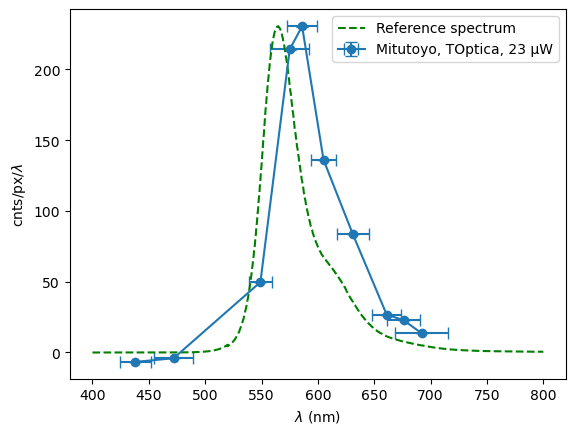

In [242]:
roi = [1, 2024, 1, 2024]
path_diode = ROOTPATH + 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/1'   # Diode laser data
path_topt = ROOTPATH + 'sets/30-01-25/Rhodamine-B 50 µM, Mitutoyo/2'    # TOptica laser data

ct_23uw, uct_23uw = plot_spectrum(path_topt, roi, label='Mitutoyo, TOptica, 23 µW')

scale_factor_23uw = np.max(emext['counts']) / np.max(ct_23uw)
plt.gca().plot(emext / scale_factor_23uw , 'g--', label='Reference spectrum')
plt.legend()

[Text(0, 0.5, 'cnts/px/$\\lambda$'),
 (420.0, 800.0),
 Text(0.5, 0, '$\\lambda$ (nm)')]

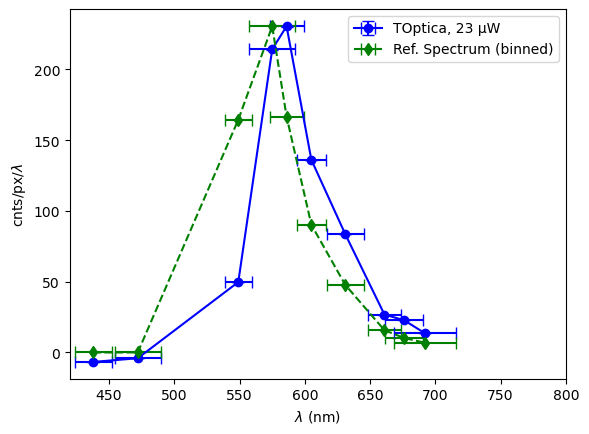

In [243]:
scale_factor_23uw_bin = np.max(embinned) / np.max(ct_23uw)
plt.errorbar(filtAv, ct_23uw, xerr=filtUn, yerr=uct_23uw, color='blue', fmt='o-', label="TOptica, 23 µW")
plt.errorbar(filtAv, embinned / scale_factor_23uw_bin, xerr=filtUn, fmt='gd--', label="Ref. Spectrum (binned)")
plt.legend()
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$', xlim=(420, 800))

# Compare to high power data

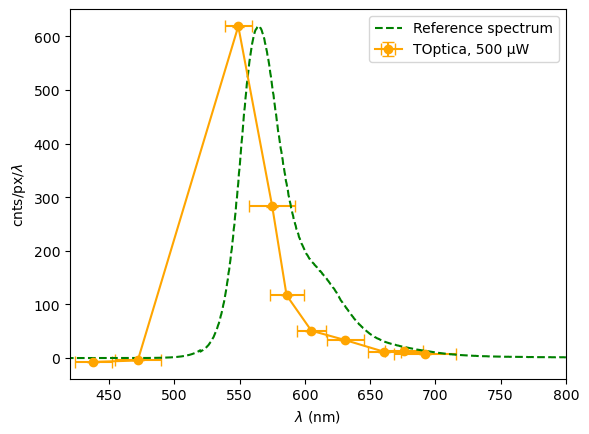

In [249]:
roi = [1, 2024, 1, 2024]

path_1mw = ROOTPATH + 'sets/16-02-25/Rhodamine-B 50 µM/1'   # At 1 mW
path_500uw = ROOTPATH + 'sets/16-02-25/Rhodamine-B 50 µM/2'   # At 500 mW

# ct1, uct1 = plot_spectrum(path_1mw, roi, label='Mitutoyo, TOptica, 1 mW')
ct_500uw, uct_500uw = plot_spectrum(path_500uw, roi, label='Mitutoyo, TOptica, 500 uW');
plt.clf()
plt.errorbar(filtAv, ct_500uw, xerr=filtUn, yerr=uct_500uw, color='orange', fmt='o-', label="TOptica, 500 µW")

scale_factor_500uw = np.max(emext['counts']) / np.max(ct)
emext['counts'] = emext['counts'] / scale_factor_500uw
plt.gca().plot(emext, 'g--', label='Reference spectrum')
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$', xlim=(420, 800))

plt.legend()

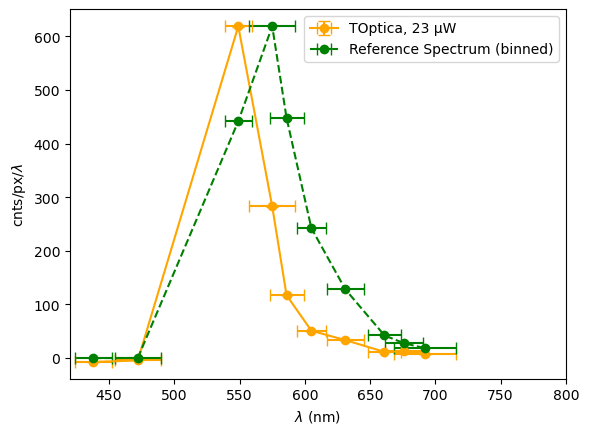

In [ ]:
# ct0, uct0 = plot_spectrum(path_topt, roi, label='Mitutoyo, TOptica, 23 µW')
scale_factor_500uw_bin = np.max(embinned) / np.max(ct)
plt.errorbar(filtAv, ct_500uw, xerr=filtUn, yerr=uct_500uw, color='orange', fmt='o-', label="TOptica, 500 µW")
plt.errorbar(filtAv, embinned / scale_factor_500uw_bin, xerr=filtUn, fmt='go--', label="Reference Spectrum (binned)")
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$', xlim=(420, 800))

plt.legend()

### Compare both powers

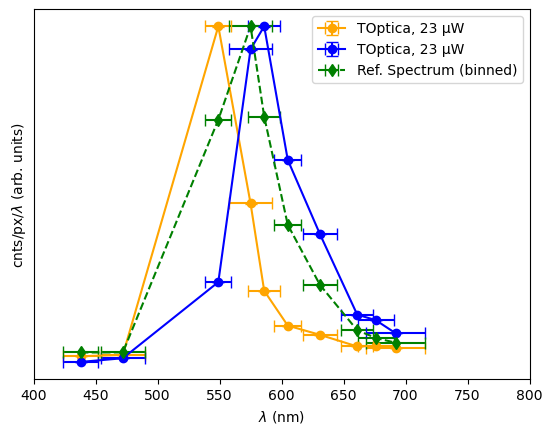

In [ ]:
scale_factor_power = np.max(ct_500uw) / np.max(ct_23uw)
plt.errorbar(filtAv, ct_500uw / scale_factor_power, xerr=filtUn, yerr=uct_500uw / scale_factor_power, color='orange', fmt='o-', label="TOptica, 500 µW")
plt.errorbar(filtAv, ct_23uw, xerr=filtUn, yerr=uct_23uw, color='blue', fmt='o-', label="TOptica, 23 µW")
plt.errorbar(filtAv, embinned / scale_factor_23uw_bin, xerr=filtUn, fmt='gd--', label="Ref. Spectrum (binned)")
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$ (arb. units)', xlim=(400, 800), yticks=[])
plt.legend()

## Exclude data at 550 nm for scaling

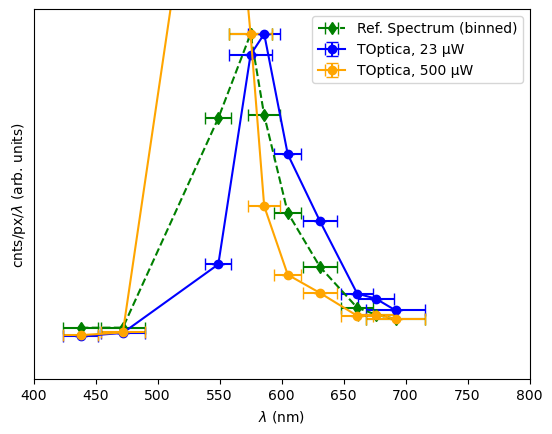

In [259]:
ct_500uw_sorted = sorted(ct_500uw)
second_largest = ct_500uw_sorted[-2]
scale_factor_second = second_largest / np.max(ct_23uw)

plt.errorbar(filtAv, embinned / scale_factor_23uw_bin, xerr=filtUn, fmt='gd--', label="Ref. Spectrum (binned)")
plt.errorbar(filtAv, ct_23uw, xerr=filtUn, yerr=uct_23uw, color='blue', fmt='o-', label="TOptica, 23 µW")
plt.errorbar(filtAv, ct_500uw / scale_factor_second, xerr=filtUn, yerr=uct_500uw / scale_factor_second, color='orange', fmt='o-', label="TOptica, 500 µW")
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$ (arb. units)', xlim=(400, 800), ylim=(-40, 250) , yticks=[])
plt.legend()

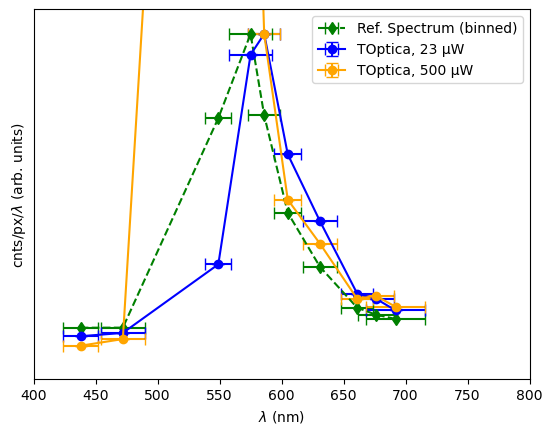

In [260]:
third_largest = ct_500uw_sorted[-3]
scale_factor_third = third_largest / np.max(ct_23uw)

plt.errorbar(filtAv, embinned / scale_factor_23uw_bin, xerr=filtUn, fmt='gd--', label="Ref. Spectrum (binned)")
plt.errorbar(filtAv, ct_23uw, xerr=filtUn, yerr=uct_23uw, color='blue', fmt='o-', label="TOptica, 23 µW")
plt.errorbar(filtAv, ct_500uw / scale_factor_third, xerr=filtUn, yerr=uct_500uw / scale_factor_third, color='orange', fmt='o-', label="TOptica, 500 µW")
plt.gca().set(xlabel='$\lambda$ (nm)', ylabel='cnts/px/$\lambda$ (arb. units)', xlim=(400, 800), ylim=(-40, 250) , yticks=[])
plt.legend()

# Plot laser spectrum

In [408]:
def read_laser_spectrum(path):
    dflas = pd.read_csv(path, sep=';', skiprows=54, names=['wavelength', 'counts'])
    dflas = dflas[:-1]
    dflas['wavelength'] = dflas['wavelength'].astype('float')
    dflas = dflas.set_index('wavelength') 
    mask = dflas['counts'] < 1e-4
    dflas.drop(dflas[mask].index, inplace=True)
    return dflas

In [545]:
toptica_path = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/average_toptica/'
flaser = glob(toptica_path + '*.csv')
flaser.sort()
flaser = flaser[2:]
flaser

['/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/average_toptica/toptica_avg100_p030nW_tint_1ms.csv',
 '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/average_toptica/toptica_avg100_p040nW_tint_1ms.csv',
 '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/average_toptica/toptica_avg100_p050nW_tint_1ms.csv',
 '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/average_toptica/toptica_avg100_p060nW_tint_1ms.csv',
 '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/spectrometer_data/laser_spectra/16-01-2025/average_toptica/toptica_avg100_p210nW_tint_1ms.csv']

In [398]:
# The coupling efficiency is: 6 mW / 310 µW
6 / 310e-3

19.35483870967742

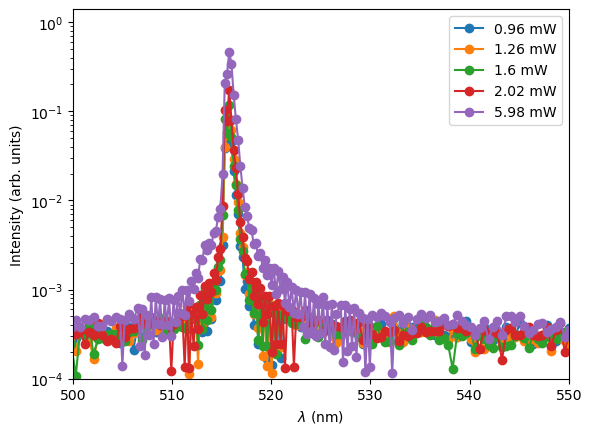

In [572]:
powlas_fiber = np.array([50, 65.5, 83, 104.5, 310])
powlas_exit = powlas_fiber * 19.3
for i, f in enumerate(flaser):
    dflas = read_laser_spectrum(f)

    name = os.path.split(f)[1][15:-4]
    
    name = name.replace('_tint_1ms', '')
    plt.plot(dflas, 'o-', label=str(round(powlas_exit[i]/1000 , 2) )+ ' mW')
plt.legend()
plt.gca().set(xlim=(500, 550), xlabel='$\lambda$ (nm)', ylabel='Intensity (arb. units)', yscale='log',  ylim=(1e-4, 1.4),);

In [568]:
def fit_lorentz(dfsub, pow=None, col=None, flag_plot=True, flag_norm=False, ax=None):
    lor = LorentzianModel()
    x = dfsub.index.values
    y = dfsub.counts.values

    params = lor.guess(y, x=x)
    result = lor.fit(y, params, x=x)
    if flag_plot:
        if ax == None: ax = plt.gca()
        line = ax.plot(dfsub, 'o', color=col, ms = 3)[0]
        col_line = line.get_color()
        ax.plot(x, result.best_fit, '-', color=col_line)
        ax.set_title(f'P = {pow} µW')
        lb = 'counts / ms'
        if flag_norm: lb += ' / µW'
        ax.set( xlabel='λ (nm)', ylabel=lb)

    return result

def arrange_results(fits, pows):
    resdf = pd.DataFrame(columns=['laser', 'center', 'error_center', 'fwhm', 'error_fwhm', 'height', 'error_height', 'chisqr', 'rscore'])
    name_cols = ['height', 'fwhm', 'center']
    for p in pows:
        for par in name_cols:
            resdf.loc[p, par] = fits[p].params[par].value
            resdf.loc[p, 'error_'+par] = fits[p].params[par].stderr

        resdf.loc[p, 'chisqr'] = fits[p].chisqr
        resdf.loc[p, 'rscore'] = fits[p].rsquared
        resdf.loc[p, 'laser'] = 'diode'
    return resdf

def plot_results(resdf, col='b'):
    cols = ['center', 'fwhm', 'height']
    lb = ['Center (nm)', 'FWHM (nm)', 'Height (counts/ms)']
    fig, ax = plt.subplots(2,2, figsize=(6,6))

    for i,c in enumerate(cols):
        j, k = i//2, i%2
        ax[j][k].errorbar(resdf[c], resdf.index, xerr=resdf['error_'+c], fmt='o', color=col)
        ax[j][k].set(xlabel=lb[i], ylabel='Power (µW)', yscale='log')

    ax[1][1].plot(resdf['chisqr'].values, resdf.index.values, 'o', color=col)
    ax[1][1].set(xlabel='χ2', ylabel='Power (µW)', yscale='log')
    fig.tight_layout()
    return ax

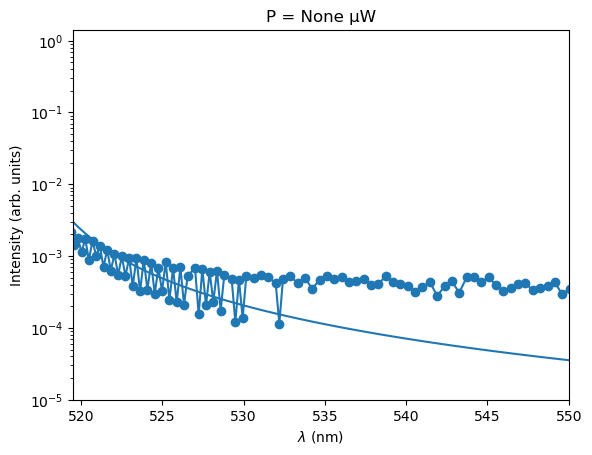

In [519]:
fit_lorentz(dflas)
plt.gca().set(xlim=(519.5, 550), xlabel='$\lambda$ (nm)', ylabel='Intensity (arb. units)', yscale='log',  ylim=(1e-5, 1.4),);


In [520]:
lasroi.index[np.argmax(lasroi.counts)]

515.7687378

## Clean and fit right tail

In [561]:
def fit_right_tail(dflas):
    lasroi0 = dflas[dflas.index > 400]
    lasroi = lasroi0[lasroi0.index < 550]
    right_tail = lasroi[lasroi.index > 519.5]
    # left_tail = lasroi[lasroi.index < 515]
    # dcounts_left = left_tail.counts.values[1:] - left_tail.counts.values[:-1]
    # mask_left = dcounts_left > np.average(dcounts_left) + 3*np.std(dcounts_left)
    # lasroi = lasroi.drop(left_tail.iloc[:-1][mask_left].index)

    dcounts_right = right_tail.counts.values[1:] - right_tail.counts.values[:-1]
    mask_right = dcounts_right > abs(np.average(dcounts_right)) + 0.5*np.std(dcounts_right)
    lasroi = lasroi.drop(right_tail.iloc[:-1][mask_right].index)
    clean_right_tail = lasroi[lasroi.index > 522.7]

    line = plt.plot(lasroi, 'o', ms = 3)[0]
    col = line.get_color()
    fit_tail = fit_lorentz(clean_right_tail, col = col)


    return fit_tail

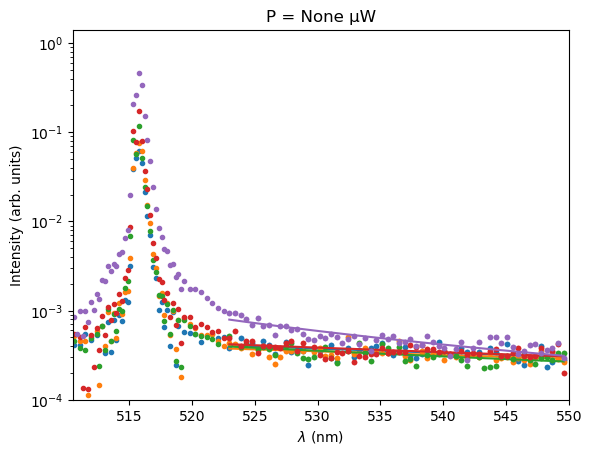

In [570]:
fits = []
for i, f in enumerate(flaser):
    dflas = read_laser_spectrum(f)
    
    fit = fit_right_tail(dflas)
    fits.append(fit)
plt.gca().set(xlim=(510.5, 550), xlabel='$\lambda$ (nm)', ylabel='Intensity (arb. units)', yscale='log',  ylim=(1e-4, 1.4),);


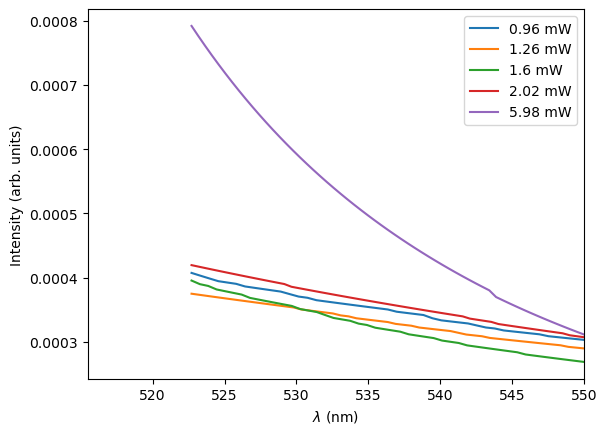

In [576]:
for i,fit in enumerate(fits):
    plt.plot(np.linspace(522.7, 550, len(fit.best_fit)), fit.best_fit, '-', label=str(round(powlas_exit[i]/1000 , 2) )+ ' mW')
plt.gca().set(xlim=(515.5, 550), xlabel='$\lambda$ (nm)', ylabel='Intensity (arb. units)',)
plt.legend()

In [ ]:
2**16

65536

# Beam profile

/Users/pabloherrero/Library/Python/3.9/lib/python/site-packages/lmfit/model.py:2179: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(**ax_kws)


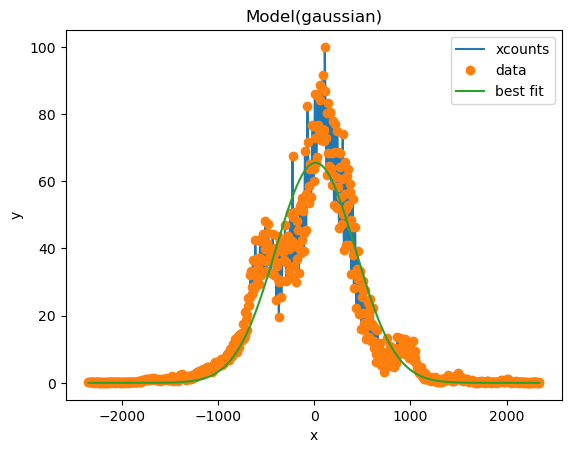

In [676]:
profdata = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-qmlab@mail.huji.ac.il/My Drive/Ba Tagging/profile_laser_on_sample/31-5-23 TOptica_515nm/laser_output/profile_x_data_#001.csv'
df = pd.read_csv(profdata, sep=';', skiprows=11, encoding="latin-1", names=['x', 'xcounts', 'y', 'ycounts', 'not'])
df = df.drop(columns=['not'])
df.plot(x='x', y='xcounts')

gaus = GaussianModel()
params = gaus.guess(df['xcounts'].values, x=df['x'].values)

result = gaus.fit(df['xcounts'].values, params=params, x=df['x'].values)
# plt.plot(result.best_fit)
result.plot_fit()
result

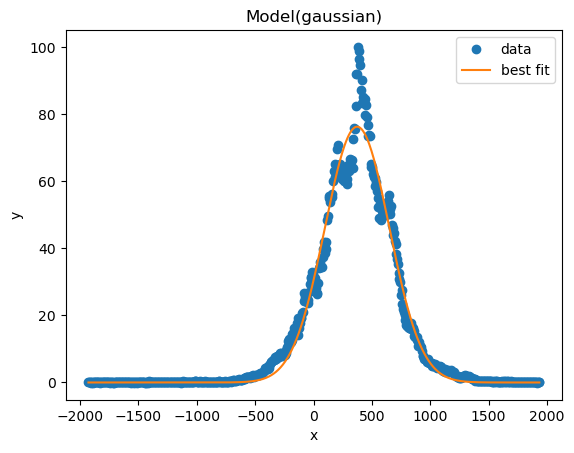

In [677]:
gaus = GaussianModel()
params = gaus.guess(df['ycounts'].values, x=df['y'].values)
params
result = gaus.fit(df['ycounts'].values, params=params, x=df['y'].values, nan_policy='omit')

result.plot_fit()
result